# 3.1 Linear Regression (2023.3.9)

## Basic elements of linear regression
- Linear model

$\hat{y} = w_1 x_1 + \cdots + w_d x_d + b$

$\hat{y} = Xw + b$

$w$: weights, $b$: bias/intercept

- Loss function

Squared error loss: $\displaystyle l^{(i)}(w,b) = \frac{1}{2} ( \hat{y}^{(i)} - y^{(i)})^2$

Average loss on training data: $\displaystyle L(w,b) = \frac{1}{n}\sum_{i=1}^{n}l^{(i)}(w,b) = \frac{1}{n}\sum_{i=1}^{n}\frac{1}{2} ( w^\top x^{(i)} + b - y^{(i)})^2$

We want to find parameters: $\displaystyle w^*,b^* = \underset{w,b}{\mathrm{argmin}}\space L(w,b)$


- Analytical solution

$w^* = ( X^\top X )^{-1} X^\top y $

- Stochastic gradient descent

**Our challenge is to generalize unseen data.**

- Prediction / Inference

## Speed up with vectorization

In [14]:
import math
import time
import numpy as np
import torch
from d2l import torch as d2l

In [15]:
n = 10000
a = torch.ones(n)
b = torch.ones(n)

In [16]:
class Timer:
    def __init__(self):
        self.times = []
        self.start()
    
    def start(self):
        """Start the timer"""
        self.tik = time.time()
        
    def stop(self):
        """Stop the time and store record in the list"""
        self.times.append(time.time() - self.tik)
        return self.times[-1]
    
    def avg(self):
        """Return average time"""
        return sum(self.times) / len(self.times)
    
    def sum(self):
        """Return total time"""
        return sum(self.times)
    
    def cumsum(self):
        """Return cumulative time"""
        return np.array(self.times).cumsum().tolist()

In [17]:
c = torch.zeros(n)
timer = Timer()
for i in range(n):
    c[i] = a[i] + b[i]
f'{timer.stop():.5f} sec'

'0.08180 sec'

In [18]:
timer.start()
d = a + b
f'{timer.stop():.5f} sec'

'0.00000 sec'

## Normal distribution and Squared error

$X$ ~ $N(\mu, \sigma^2)$

In [19]:
def normal(x, mu, sigma):
    p = 1 / math.sqrt(2 * math.pi * sigma**2)
    return p * np.exp(-0.5 / sigma**2 * (x - mu)**2)

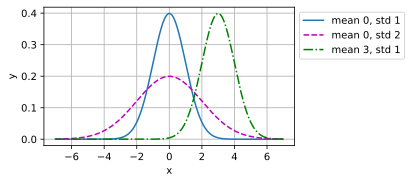

In [30]:
x = np.arange(-7, 7, 0.01)

params = [(0, 1), (0, 2), (3, 1)]

d2l.plot(x, [normal(x, mu, sigma) for mu, sigma in params],
         xlabel='x', ylabel='y', figsize=(4.5, 2.5))
d2l.plt.legend([f'mean {mu}, std {sigma}' for mu, sigma in params], bbox_to_anchor=(1, 1))
d2l.plt.show()

## From linear regression to Deep networks

In [ ]:
# d: feature dimensionality

# fully-connected layer

# dense layer

---

# 3.2 Linear Regression from scratch (2023.3.10)

## Generate dataset

In [1]:
import random
import torch
from d2l import torch as d2l

In [4]:
def synthetic_data(w, b, num_examples):
    X = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape)
    return X, y.reshape(-1, 1)

In [5]:
true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

In [6]:
print(f'features: {features[0]},\nlabel: {labels[0]}')

features: tensor([ 0.6809, -0.1674]),
label: tensor([6.1312])


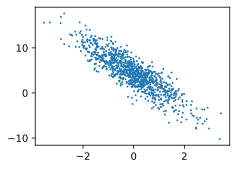

In [14]:
d2l.set_figsize()
d2l.plt.scatter(features[:, 1].detach().numpy(), labels.detach().numpy(), 1)
d2l.plt.show()

## Load dataset

In [15]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    # Sort the data randomly
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(indices[i:min(i + batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]

In [17]:
batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tensor([[-1.1467, -0.3226],
        [ 0.7974,  0.8848],
        [ 0.9911,  1.5573],
        [ 1.8780,  0.3186],
        [-0.2416,  0.3385],
        [ 1.7869, -0.3474],
        [-0.5288, -1.5761],
        [ 0.4011, -0.0539],
        [ 0.8820,  0.1779],
        [ 0.6842,  1.6198]]) 
 tensor([[3.0087],
        [2.8035],
        [0.8855],
        [6.8635],
        [2.5581],
        [8.9567],
        [8.4962],
        [5.1871],
        [5.3660],
        [0.0659]])


## Initialize model parameters

In [33]:
# requires_grad !

w = torch.normal(0, 0.01, size=(2, 1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

## Define the model

In [34]:
def linreg(X, w, b):
    return torch.matmul(X, w) + b

## Define loss function

In [35]:
def squared_loss(y_hat, y):
    """Squared Error Loss"""
    return (y_hat - y.reshape(y_hat.shape))**2 / 2

## Define optimization algorithm

In [36]:
def sgd(params, lr, batch_size):
    """Mini-batch stochastic gradient descent"""
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

## Training

In [37]:
# Hyperparameter -> learning rate, number of epochs

In [38]:
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss

In [39]:
for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y)
        l.sum().backward()
        sgd([w, b], lr, batch_size) # Update weights and bias according to their gradients
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):.6f}')

epoch 1, loss 0.022738
epoch 2, loss 0.000084
epoch 3, loss 0.000051


In [40]:
print(f'Estimation error of w: {true_w - w.reshape(true_w.shape)}')
print(f'Estimation error of b: {true_b - b}')

Estimation error of w: tensor([-0.0001,  0.0004], grad_fn=<SubBackward0>)
Estimation error of b: tensor([0.0005], grad_fn=<RsubBackward1>)


---

# 3.3 Linear Regression with PyTorch (2023.3.10)

## Generate dataset

In [53]:
import numpy as np
import torch
from torch.utils import data
from d2l import torch as d2l

In [54]:
true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = d2l.synthetic_data(true_w, true_b, 1000)

## Load dataset

In [55]:
def load_array(data_arrays, batch_size, is_train=True):
    """Construct a PyTorch data iterator"""
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)

In [56]:
batch_size = 10
data_iter = load_array((features, labels), batch_size)

In [57]:
next(iter(data_iter))

[tensor([[-1.5005, -0.3397],
         [ 0.7297, -0.7771],
         [-0.1491, -1.4116],
         [-0.4371, -0.1491],
         [ 0.4565,  0.3458],
         [ 0.0145,  1.5551],
         [-1.7140, -0.7948],
         [-1.5600,  0.7660],
         [ 0.8176,  0.2317],
         [ 0.6411, -1.6708]]),
 tensor([[ 2.3486],
         [ 8.2906],
         [ 8.7030],
         [ 3.8340],
         [ 3.9482],
         [-1.0521],
         [ 3.4727],
         [-1.5278],
         [ 5.0432],
         [11.1697]])]

## Define the model

In [58]:
# nn -> Neural Networks

from torch import nn

net = nn.Sequential(nn.Linear(2, 1))

## Initialize model parameters

In [59]:
net[0].weight.data.normal_(0, 0.01)
net[0].bias.data.fill_(0)

tensor([0.])

## Define loss function

In [60]:
loss = nn.MSELoss()

## Define optimizer

In [61]:
trainer = torch.optim.SGD(net.parameters(), lr=0.03)

## Training

In [62]:
num_epochs = 3

for epoch in range(num_epochs):
    for X, y in data_iter:
        l = loss(net(X), y)
        trainer.zero_grad()
        l.backward()
        trainer.step()
    l = loss(net(features), labels)
    print(f'epoch {epoch + 1}, loss {l:.6f}')

epoch 1, loss 0.000278
epoch 2, loss 0.000103
epoch 3, loss 0.000102


In [63]:
w = net[0].weight.data
b = net[0].bias.data
print(f'Estimation error of w: {true_w - w.reshape(true_w.shape)}')
print(f'Estimation error of b: {true_b - b}')

Estimation error of w: tensor([ 0.0002, -0.0003])
Estimation error of b: tensor([-0.0006])


---

# 3.4 Softmax regression (2023.3.10)

## Classification problem

**One-hot encoding**:

{Dog, Cat, Chicken}

(0, 0, 1) Dog

(0, 1, 0) Cat

(1, 0, 0) Chicken

## Softmax operation

$\hat{y} = softmax(o)$

$\displaystyle \hat{y}_j = \frac{\exp(o_j)}{\underset{k}{\sum}\exp(o_k)}$

## Loss function

**Cross-entropy loss**: $\displaystyle l(y, \hat{y}) = -\sum_{j=1}^q y_j \log \hat{y}_j$

## Model Prediction and Evaluation

e.g. Accuracy

---

# 3.5 Image classification dataset - Fashion MNIST (2023.3.10)

In [65]:
import torch
import torchvision
from torch.utils import data
from torchvision import transforms
from d2l import torch as d2l

d2l.use_svg_display()

## Load dataset

In [76]:
trans = transforms.ToTensor() # PIL -> float32
mnist_train = torchvision.datasets.FashionMNIST(root='data', train=True, transform=trans, download=True)
mnist_test = torchvision.datasets.FashionMNIST(root='data', train=False, transform=trans, download=True)

In [79]:
len(mnist_train), len(mnist_test)

(60000, 10000)

In [80]:
# [c, h, w]

mnist_train[0][0].shape

torch.Size([1, 28, 28])

In [81]:
def get_fashion_mnist_labels(labels):
    """Return text labels for Fashion-MNIST dataset"""
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
                   'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return[text_labels[int(i)] for i in labels]

In [82]:
def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):
    """Draw image list"""
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = d2l.plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        if torch.is_tensor(img):
            ax.imshow(img.numpy())
        else:
            ax.imshow(img)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    return axes

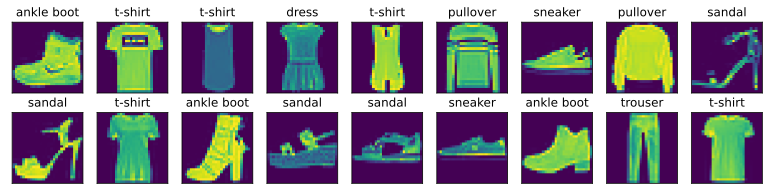

In [85]:
X, y = next(iter(data.DataLoader(mnist_train, batch_size=18)))
show_images(X.reshape(18, 28, 28), 2, 9, titles=get_fashion_mnist_labels(y))
d2l.plt.show()

## Load mini-batch

In [91]:
batch_size = 256

def get_dataloader_workers():
    """Use 4 threads to load data"""
    return 4

train_iter = data.DataLoader(mnist_train, batch_size, shuffle=True, num_workers=get_dataloader_workers())

In [92]:
timer = d2l.Timer()
for X, y in train_iter:
    continue
f'{timer.stop():.2f} sec'

'2.31 sec'

## Integrate pieces

In [94]:
def load_data_fashion_mnist(batch_size, resize=None):
    """Download Fashion-MNIST, and then load it in RAM."""
    trans = [transforms.ToTensor()]
    if resize:
        trans.insert(0, transforms.Resize(resize))
    trans = transforms.Compose(trans)
    mnist_train = torchvision.datasets.FashionMNIST(root='data', train=True, transform=trans, download=True)
    mnist_test = torchvision.datasets.FashionMNIST(root='data', train=False, transform=trans, download=True)
    return (data.DataLoader(mnist_train, batch_size, shuffle=True, num_workers=get_dataloader_workers()),
            data.DataLoader(mnist_test, batch_size, shuffle=False, num_workers=get_dataloader_workers()))

In [95]:
train_iter, test_iter = load_data_fashion_mnist(32, resize=64)
for X, y in train_iter:
    print(X.shape, X.dtype, y.shape, y.dtype)
    break

torch.Size([32, 1, 64, 64]) torch.float32 torch.Size([32]) torch.int64


---

# 3.6 Softmax regression from scratch (2023.3.13)

In [180]:
import torch
import torchvision
from torch.utils import data
from torchvision import transforms
from d2l import torch as d2l

from IPython import display

In [181]:
def get_dataloader_workers():
    """Use 4 threads to load data"""
    return 4

def load_data_fashion_mnist(batch_size, resize=None):
    """Download Fashion-MNIST, and then load it in RAM."""
    trans = [transforms.ToTensor()]
    if resize:
        trans.insert(0, transforms.Resize(resize))
    trans = transforms.Compose(trans)
    mnist_train = torchvision.datasets.FashionMNIST(root='data', train=True, transform=trans, download=True)
    mnist_test = torchvision.datasets.FashionMNIST(root='data', train=False, transform=trans, download=True)
    return (data.DataLoader(mnist_train, batch_size, shuffle=True, num_workers=get_dataloader_workers()),
            data.DataLoader(mnist_test, batch_size, shuffle=False, num_workers=get_dataloader_workers()))

In [182]:
batch_size = 256
train_iter, test_iter = load_data_fashion_mnist(batch_size)

## Initialize model parameters

In [183]:
# 28 * 28 = 784
# 10 classes

num_inputs = 784
num_outputs = 10

In [184]:
W = torch.normal(0, 0.01, size=(num_inputs, num_outputs), requires_grad=True)
b = torch.zeros(num_outputs, requires_grad=True)

## Define softmax operation

In [185]:
X = torch.tensor([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
X, X.sum(0, keepdim=True), X.sum(1, keepdim=True)

(tensor([[1., 2., 3.],
         [4., 5., 6.]]),
 tensor([[5., 7., 9.]]),
 tensor([[ 6.],
         [15.]]))

In [186]:
def softmax(X):
    X_exp = torch.exp(X)
    partition = X_exp.sum(1, keepdim=True)
    return X_exp / partition # Broadcast

In [187]:
X = torch.normal(0, 1, (2, 5))
X_prob = softmax(X)
X_prob, X_prob.sum(1)

(tensor([[0.1848, 0.2812, 0.3555, 0.1475, 0.0310],
         [0.5034, 0.0644, 0.0907, 0.1822, 0.1593]]),
 tensor([1.0000, 1.0000]))

## Define the model

In [188]:
def net(X):
    return softmax(torch.matmul(X.reshape((-1, W.shape[0])), W) + b)

## Define loss function

In [189]:
y = torch.tensor([0, 2])
y_hat = torch.tensor([[0.1, 0.3, 0.6], [0.3, 0.2, 0.5]])
y_hat[[0, 1], y]

tensor([0.1000, 0.5000])

In [190]:
- torch.log(torch.tensor(0.1))

tensor(2.3026)

In [191]:
- torch.log(torch.tensor(0.5))

tensor(0.6931)

In [192]:
def cross_entropy(y_hat, y):
    return - torch.log(y_hat[range(len(y_hat)), y])

cross_entropy(y_hat, y)

tensor([2.3026, 0.6931])

## Classification accuracy

In [193]:
def accuracy(y_hat, y):
    """Return number of correct prediction"""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())

In [194]:
accuracy(y_hat, y) / len(y)

0.5

In [195]:
class Accumulator:
    """Accumulate based on n variables"""
    def __init__(self, n):
        self.data = [0.0] * n
        
    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]
        
    def reset(self):
        self.data = [0.0] * len(self.data)
        
    def __getitem__(self, idx):
        return self.data[idx]

In [196]:
def evaluate_accuracy(net, data_iter):
    """Calculate model accuracy on a given dataset"""
    if isinstance(net, torch.nn.Module):
        net.eval()
    metric = Accumulator(2) # Correct prediction & Total prediction
    with torch.no_grad():
        for X, y in data_iter:
            metric.add(accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

In [197]:
evaluate_accuracy(net, test_iter)

0.081

## Training

In [198]:
def train_epoch_ch3(net, train_iter, loss, updater):
    # Train mode
    if isinstance(net, torch.nn.Module):
        net.train()
    # Total train loss, total train accuracy, number of observation
    metric = Accumulator(3)
    for X, y in train_iter:
        # Calculate gradient and update parameters
        y_hat = net(X)
        l = loss(y_hat, y)
        if isinstance(updater, torch.optim.Optimizer):
            # User PyTorch optimizer and loss function
            updater.zero_grad()
            l.mean().backward()
            updater.step()
        else:
            # Use given optimizer and loss function
            l.sum().backward()
            updater(X.shape[0])
        metric.add(float(l.sum()), accuracy(y_hat, y), y.numel())
    # Return train loss and accuracy
    return metric[0] / metric[2], metric[1] / metric[2]

In [199]:
class Animator:
    """Draw data in animation"""
    def __init__(self, xlabel=None, ylabel=None, legend=None,
                 xlim=None, ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1, figsize=(3.5, 2.5)):
        if legend is None:
            legend = []
        d2l.use_svg_display()
        self.fig, self.axes = d2l.plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # Capture parameters using Lambda function
        self.config_axes = lambda: d2l.set_axes(self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts
        
    def add(self, x, y):
        if not hasattr(y, '__len__'):
            y = [y]
        n = len(y)
        if not hasattr(x, '__len__'):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

In [200]:
def train_ch3(net, train_iter, test_iter, loss, num_epochs, updater):
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.3, 0.9],
                        legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        train_metrics = train_epoch_ch3(net, train_iter, loss, updater)
        test_acc = evaluate_accuracy(net, test_iter)
        animator.add(epoch+1, train_metrics + (test_acc,)) # (float,) -> tuple /// e.g. (5, 6) + (7,) -> (5, 6, 7)
    train_loss, train_acc = train_metrics
    assert train_loss < 0.5, train_loss
    assert train_acc <= 1 and train_acc > 0.7, train_acc
    assert test_acc <= 1 and test_acc > 0.7, test_acc

In [201]:
lr = 0.1

def updater(batch_size):
    return d2l.sgd([W, b], lr, batch_size)

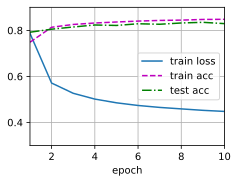

In [202]:
num_epochs = 10
train_ch3(net, train_iter, test_iter, cross_entropy, num_epochs, updater)

## Prediction

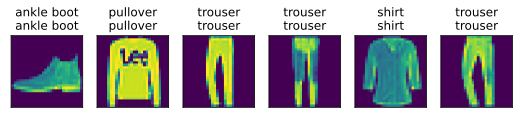

In [204]:
def predict_ch3(net, test_iter, n=6):
    for X, y in test_iter:
        break
    trues = d2l.get_fashion_mnist_labels(y)
    preds = d2l.get_fashion_mnist_labels(net(X).argmax(axis=1))
    titles = [true + '\n' + pred for true, pred in zip(trues, preds)]
    d2l.show_images(X[0:n].reshape((n, 28, 28)), 1, n, titles=titles[0:n])
    
predict_ch3(net, test_iter)

---

# 3.7 Softmax regression with PyTorch (2023.3.13)

In [206]:
import torch
from torch import nn
from d2l import torch as d2l

In [207]:
def get_dataloader_workers():
    """Use 4 threads to load data"""
    return 4

def load_data_fashion_mnist(batch_size, resize=None):
    """Download Fashion-MNIST, and then load it in RAM."""
    trans = [transforms.ToTensor()]
    if resize:
        trans.insert(0, transforms.Resize(resize))
    trans = transforms.Compose(trans)
    mnist_train = torchvision.datasets.FashionMNIST(root='data', train=True, transform=trans, download=True)
    mnist_test = torchvision.datasets.FashionMNIST(root='data', train=False, transform=trans, download=True)
    return (data.DataLoader(mnist_train, batch_size, shuffle=True, num_workers=get_dataloader_workers()),
            data.DataLoader(mnist_test, batch_size, shuffle=False, num_workers=get_dataloader_workers()))

In [208]:
batch_size = 256
train_iter, test_iter = load_data_fashion_mnist(batch_size)

## Initialize model parameters

In [209]:
# PyTorch does not change input shape implicitly
# Thus, we use Flatten() ahead of the linear layer to adjust shape of the network's input

net = nn.Sequential(nn.Flatten(), nn.Linear(28*28, 10))

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

net.apply(init_weights)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=10, bias=True)
)

## Softmax revisited

In [210]:
# Avoid overflow and underflow due to extreme values caused by large number and exponential operation

In [211]:
loss = nn.CrossEntropyLoss(reduction='none')

## Optimization algorithm

In [212]:
trainer = torch.optim.SGD(net.parameters(), lr=0.1)

## Training

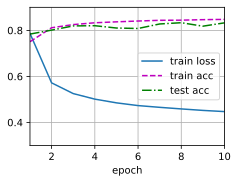

In [213]:
num_epochs = 10
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)